In [196]:
import numpy as np
from geopy.distance import geodesic
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
import re
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [198]:
final_matched_data = pd.read_csv('/Users/biankapaul/Downloads/matched_data_20_miles.csv')
pd.set_option('display.max_columns', None)

print(final_matched_data['fire_occurred'].sum())
final_matched_data.head()

2367


Stn Id           Stn Name               CIMIS Region        Date  Jul  \
0     181  Westmorland North  Imperial/Coachella Valley  2021-01-01    1   
1     181  Westmorland North  Imperial/Coachella Valley  2021-01-02    2   
2     181  Westmorland North  Imperial/Coachella Valley  2021-01-03    3   
3     181  Westmorland North  Imperial/Coachella Valley  2021-01-04    4   
4     181  Westmorland North  Imperial/Coachella Valley  2021-01-05    5   

   ETo (mm) qc  Precip (mm) qc.1  Sol Rad (W/sq.m) qc.2  Avg Vap Pres (kPa)  \
0      1.96             0.0                  159.0    R                 0.7   
1      1.63             0.0                  152.0                      0.8   
2      1.57  R          0.0                  149.0                      0.8   
3      1.69  R          0.0                  154.0                      0.9   
4      1.74             0.0                  162.0    R                 0.9   

  qc.3  Max Air Temp (C) qc.4  Min Air Temp (C) qc.5  Avg Air Temp (C) qc.6  \
0                   20.8                    3.9                   12.4        
1                   19.3                    1.0                    9.2        
2                   20.5                    1.5                    9.8        
3                   22.8                    2.3                   10.4        
4                   23.7                    1.5                   10.2        

   Max Rel Hum (%) qc.7  Min Rel Hum (%) qc.8  Avg Rel Hum (%) qc.9  \
0             78.0                  31.0                  51.0        
1             85.0                  39.0                  65.0        
2             88.0                  35.0                  67.0        
3             88.0                  36.0                  68.0        
4             92.0                  42.0                  73.0        

   Dew Point (C) qc.10  Avg Wind Speed (m/s) qc.11  Wind Run (km) qc.12  \
0            2.5                         1.2                 99.9         
1            2.9                         0.5                 40.6         
2            3.9                         0.5                 40.8         
3            4.6                         0.5                 39.0         
4            5.5                         0.6                 48.5         

   Avg Soil Temp (C) qc.13  StationNbr   Latitude  Longitude  fire_occurred  
0               11.0               181  33.078611 -115.66056              0  
1               11.0               181  33.078611 -115.66056              0  
2               10.9               181  33.078611 -115.66056              0  
3               10.8               181  33.078611 -115.66056              0  
4               10.9               181  33.078611 -115.66056              0

In [200]:
qc_columns = ['qc.1', 'qc.2', 'qc.3', 'qc.4', 'qc.5', 'qc.6', 'qc.7', 'qc.8', 'qc.9', 'qc.10', 'qc.11', 'qc.12', 'qc.13']


excluded_flags = {'M', 'I', 'S'} #these are flags that are unreliable https://cimis.water.ca.gov/Content/PDF/CurrentFlags2.pdf


#convert all qc cols to strings 
qc_data = final_matched_data[qc_columns].astype(str)

# mark rows that contain any excluded flag
def contains_excluded_flag(series, excluded_flags):
    return series.apply(lambda val: any(flag in val for flag in excluded_flags))

# check across each QC column
column_masks = qc_data.apply(lambda col: ~contains_excluded_flag(col, excluded_flags)) #pass each column in data to contains excluded flag function and keep rows that are true

# keep only true rows that don't have MIS
mask = column_masks.all(axis=1)

# this is to check how many fires would be removed
excluded_fire_count = final_matched_data[~mask]['fire_occurred'].sum()

# check how many rows removed 
rows_removed = (~mask).sum()

print(f"Fires excluded by removing rows with M/I/S QC flags: {excluded_fire_count}")
print(f"Total rows removed: {rows_removed}")

cleaned_data = final_matched_data[mask]
cleaned_data.shape

Fires excluded by removing rows with M/I/S QC flags: 96
Total rows removed: 13913


(202732, 37)

In [201]:
cleaned_data.head()

Stn Id           Stn Name               CIMIS Region        Date  Jul  \
0     181  Westmorland North  Imperial/Coachella Valley  2021-01-01    1   
1     181  Westmorland North  Imperial/Coachella Valley  2021-01-02    2   
2     181  Westmorland North  Imperial/Coachella Valley  2021-01-03    3   
3     181  Westmorland North  Imperial/Coachella Valley  2021-01-04    4   
4     181  Westmorland North  Imperial/Coachella Valley  2021-01-05    5   

   ETo (mm) qc  Precip (mm) qc.1  Sol Rad (W/sq.m) qc.2  Avg Vap Pres (kPa)  \
0      1.96             0.0                  159.0    R                 0.7   
1      1.63             0.0                  152.0                      0.8   
2      1.57  R          0.0                  149.0                      0.8   
3      1.69  R          0.0                  154.0                      0.9   
4      1.74             0.0                  162.0    R                 0.9   

  qc.3  Max Air Temp (C) qc.4  Min Air Temp (C) qc.5  Avg Air Temp (C) qc.6  \
0                   20.8                    3.9                   12.4        
1                   19.3                    1.0                    9.2        
2                   20.5                    1.5                    9.8        
3                   22.8                    2.3                   10.4        
4                   23.7                    1.5                   10.2        

   Max Rel Hum (%) qc.7  Min Rel Hum (%) qc.8  Avg Rel Hum (%) qc.9  \
0             78.0                  31.0                  51.0        
1             85.0                  39.0                  65.0        
2             88.0                  35.0                  67.0        
3             88.0                  36.0                  68.0        
4             92.0                  42.0                  73.0        

   Dew Point (C) qc.10  Avg Wind Speed (m/s) qc.11  Wind Run (km) qc.12  \
0            2.5                         1.2                 99.9         
1            2.9                         0.5                 40.6         
2            3.9                         0.5                 40.8         
3            4.6                         0.5                 39.0         
4            5.5                         0.6                 48.5         

   Avg Soil Temp (C) qc.13  StationNbr   Latitude  Longitude  fire_occurred  
0               11.0               181  33.078611 -115.66056              0  
1               11.0               181  33.078611 -115.66056              0  
2               10.9               181  33.078611 -115.66056              0  
3               10.8               181  33.078611 -115.66056              0  
4               10.9               181  33.078611 -115.66056              0

In [204]:
feature_cols = [
    'ETo (mm)', 'Precip (mm)', 'Sol Rad (W/sq.m)', 'Avg Vap Pres (kPa)',
    'Max Air Temp (C)', 'Min Air Temp (C)', 'Avg Air Temp (C)',
    'Max Rel Hum (%)', 'Min Rel Hum (%)', 'Avg Rel Hum (%)',
    'Dew Point (C)', 'Avg Wind Speed (m/s)', 'Wind Run (km)', 'Avg Soil Temp (C)'
]

label = 'fire_occurred'

filtered_clean_data = pd.concat([cleaned_data[feature_cols], cleaned_data[[label]]], axis=1)

filtered_clean_data.head()
print(filtered_clean_data.dtypes)

ETo (mm)                float64
Precip (mm)             float64
Sol Rad (W/sq.m)        float64
Avg Vap Pres (kPa)      float64
Max Air Temp (C)        float64
Min Air Temp (C)        float64
Avg Air Temp (C)        float64
Max Rel Hum (%)         float64
Min Rel Hum (%)         float64
Avg Rel Hum (%)         float64
Dew Point (C)           float64
Avg Wind Speed (m/s)    float64
Wind Run (km)           float64
Avg Soil Temp (C)       float64
fire_occurred             int64
dtype: object


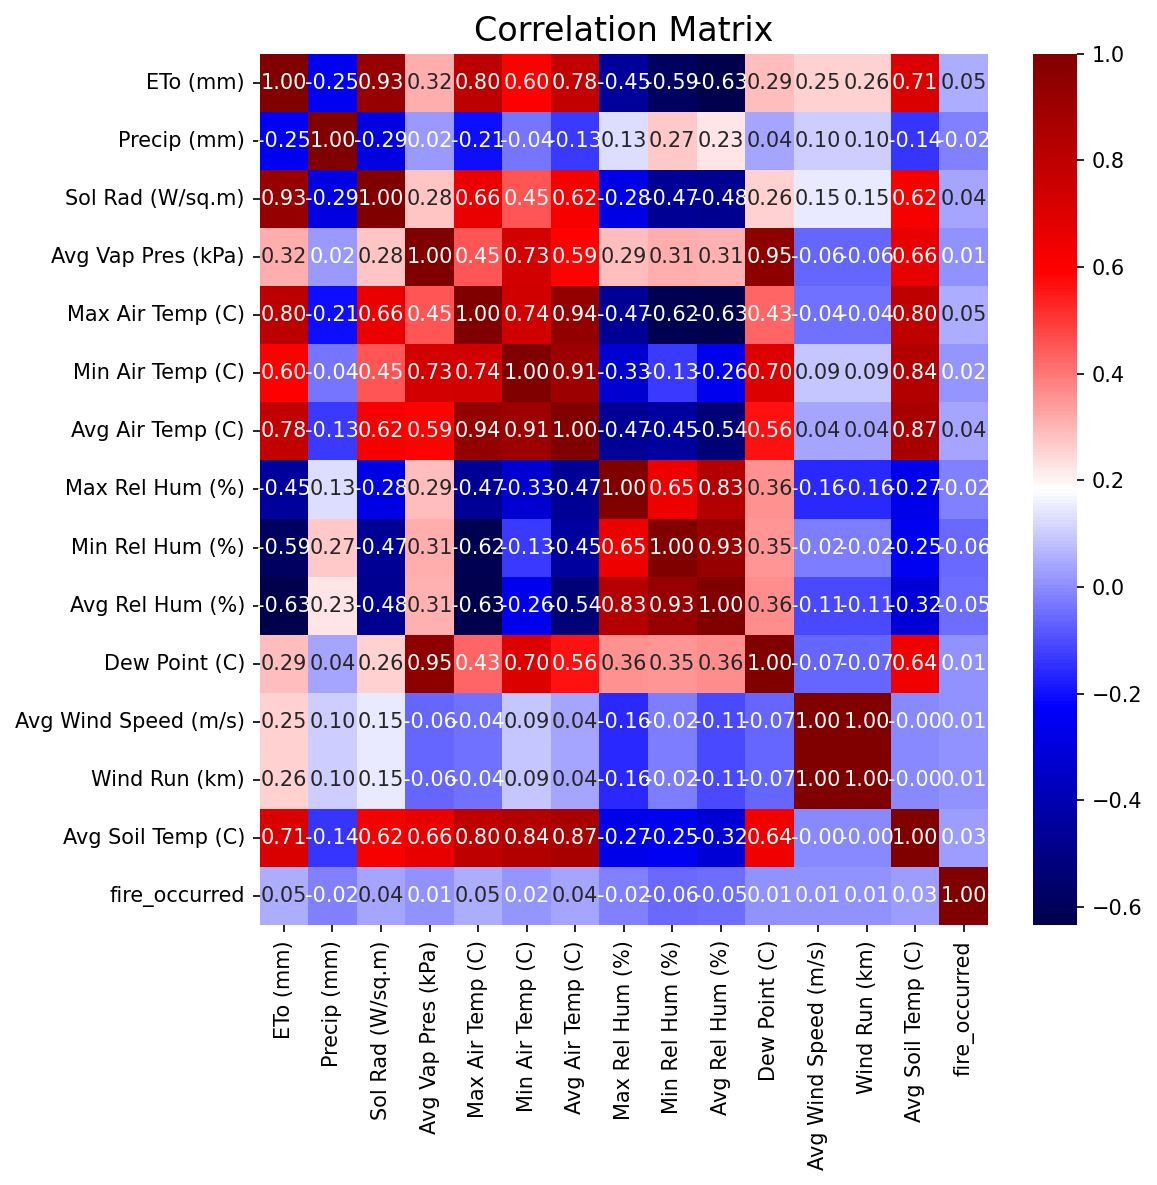

In [206]:
plt.figure(figsize=(8, 8), dpi=150)  # add dpi
sns.heatmap(filtered_clean_data.corr(),annot=True,fmt='.2f',cmap='seismic',
)
plt.title("Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()

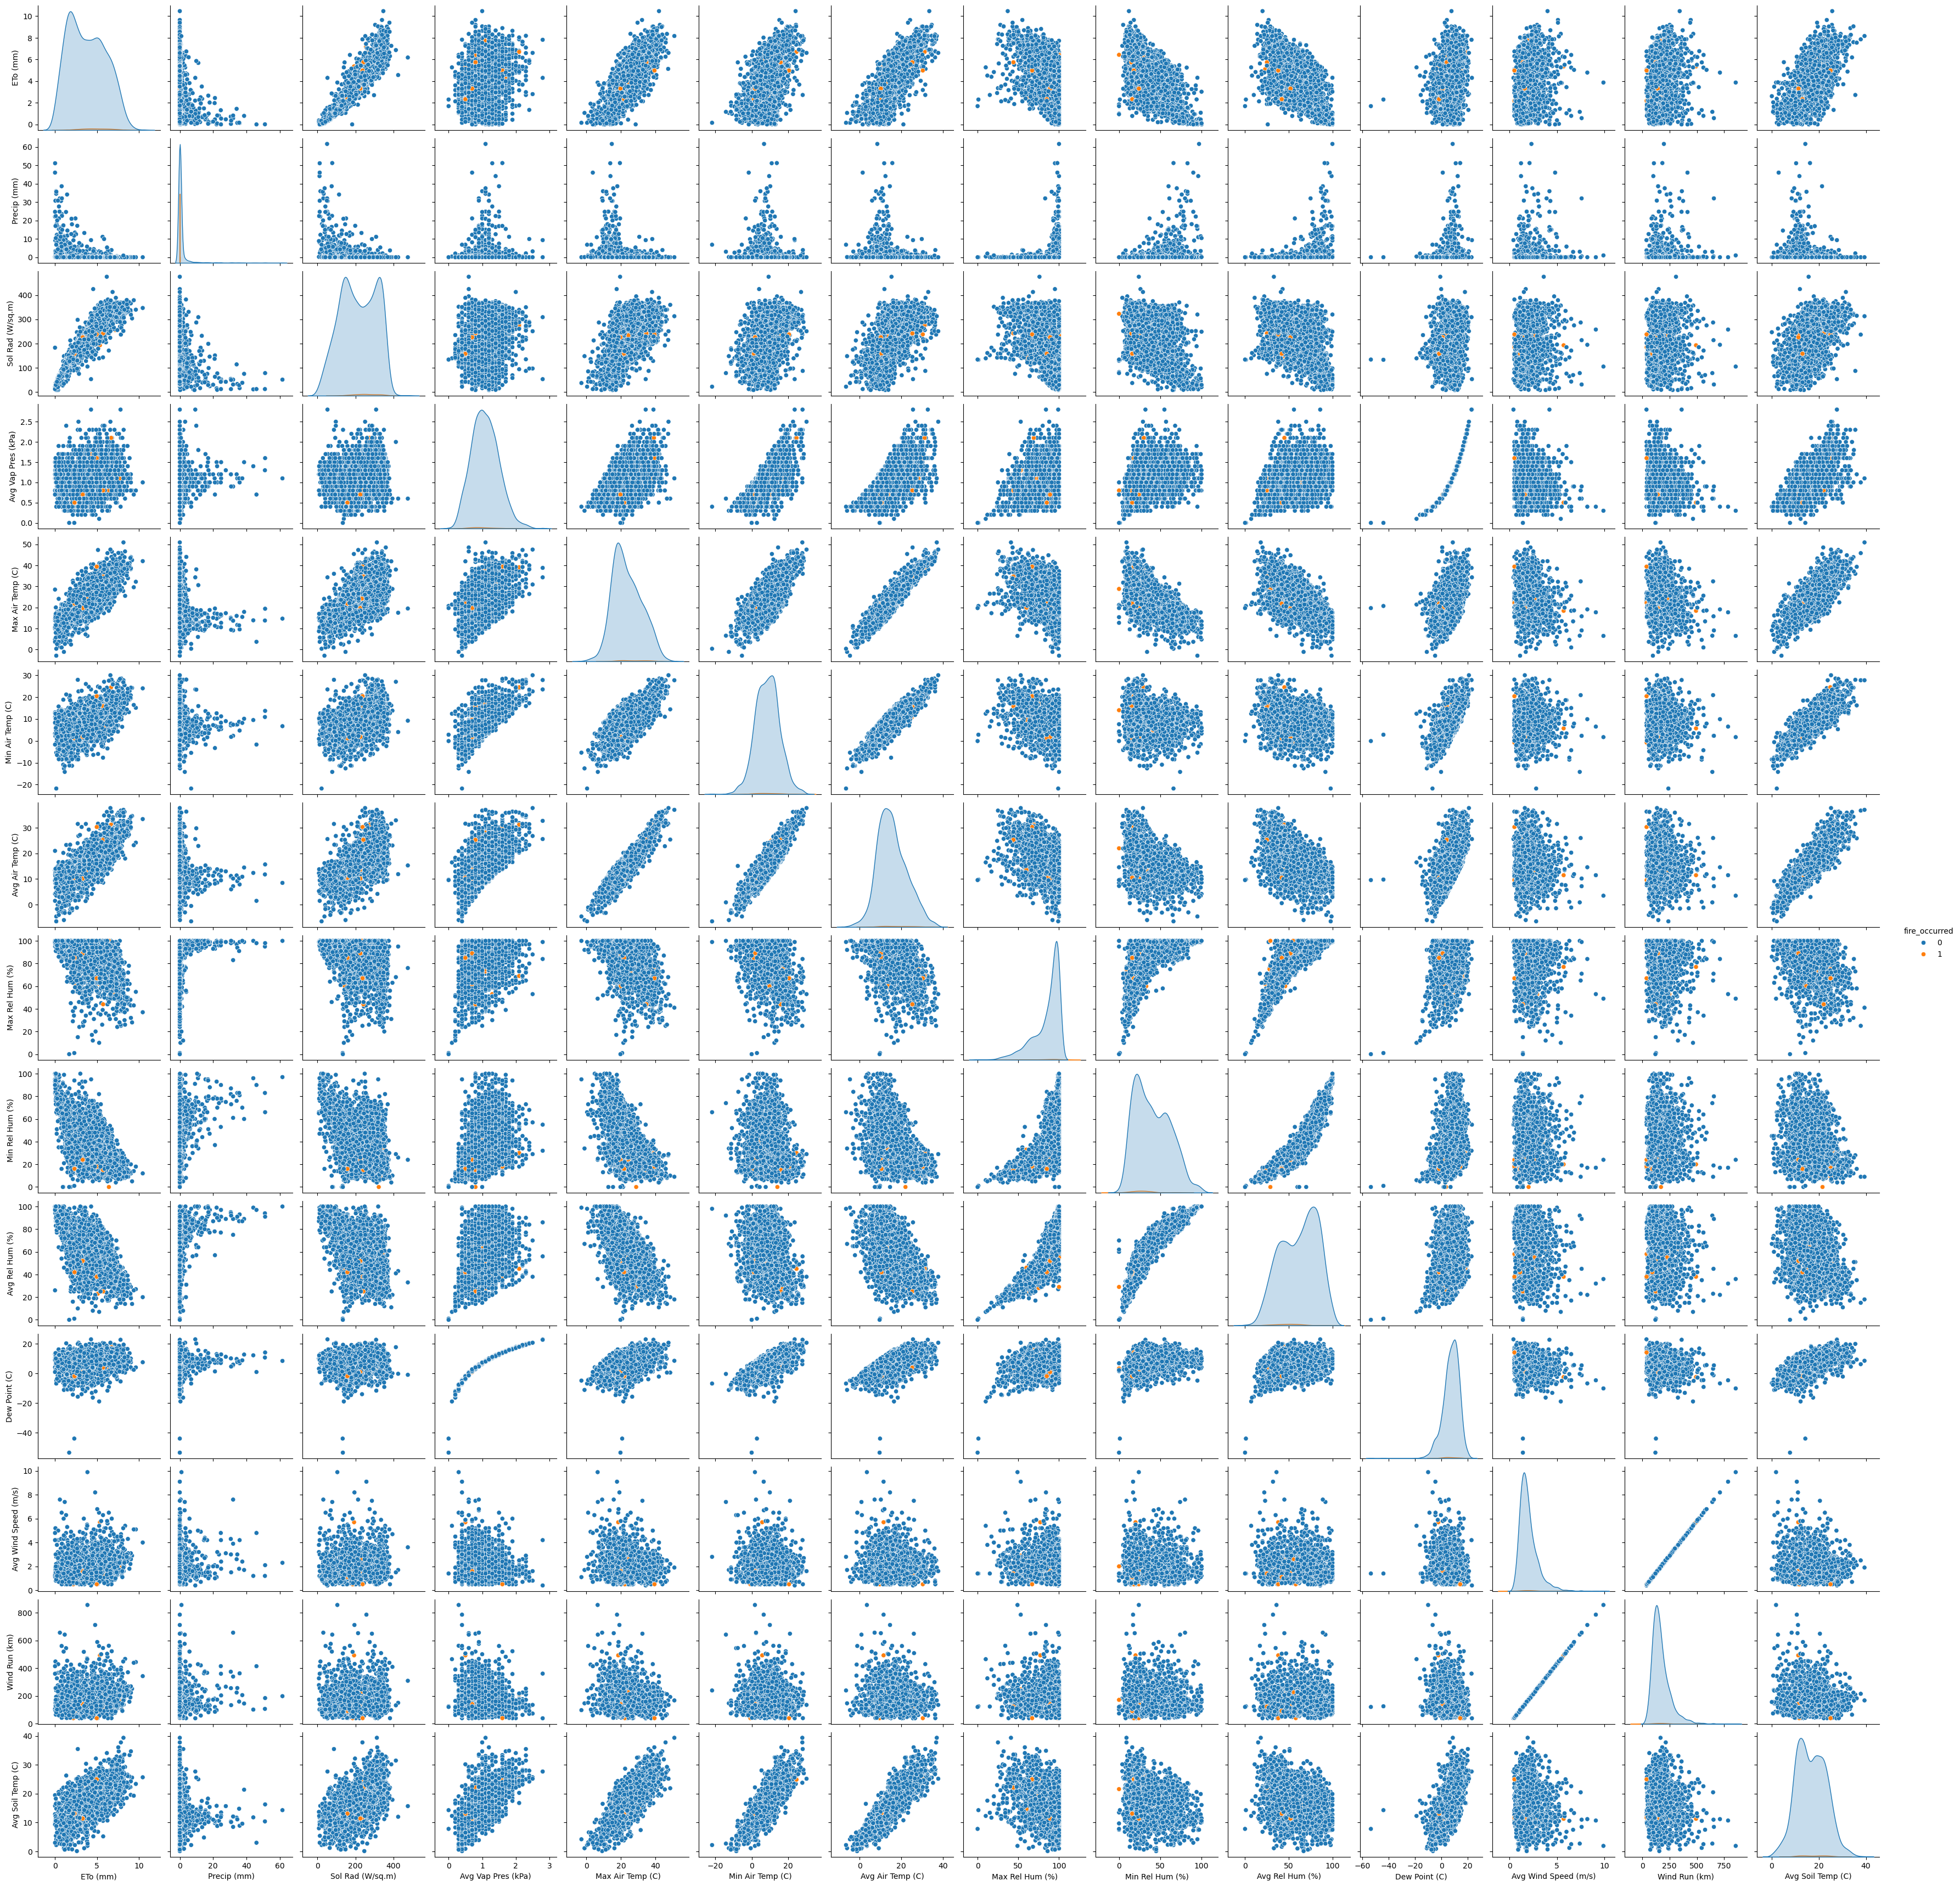

In [208]:
sns.pairplot(filtered_clean_data.sample(2500), hue='fire_occurred') #2500 to roughly capture 1 fire in this hue

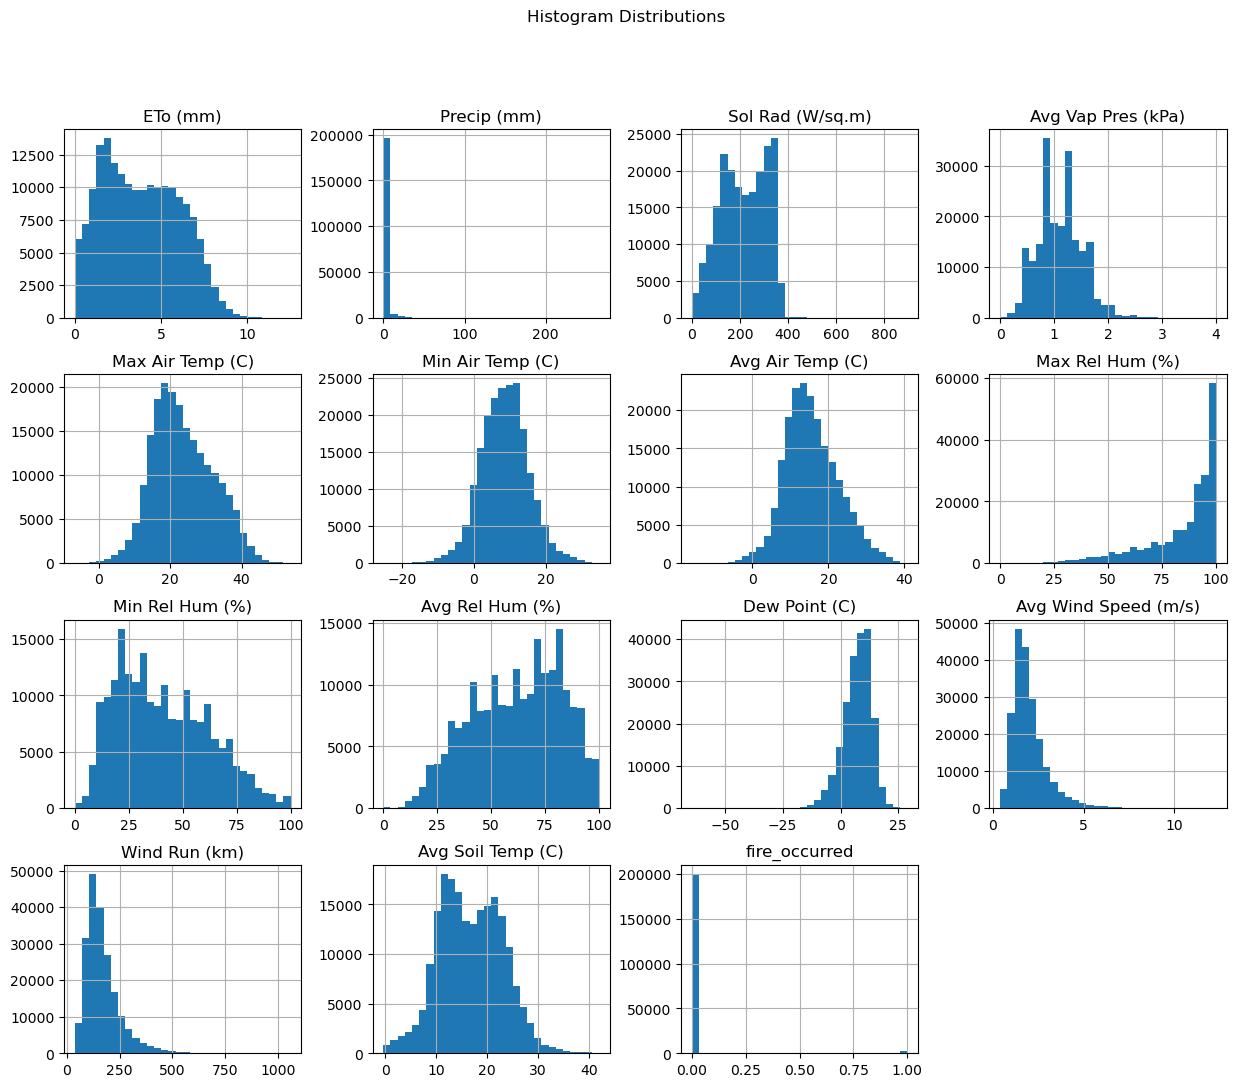

In [209]:
filtered_clean_data.hist(figsize=(15, 12), bins=30)
plt.suptitle("Histogram Distributions")
plt.show()

In [210]:

x_data = cleaned_data[feature_cols]
y_data = cleaned_data[label]

#split data for train/test
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=1234)


def normalize_features(df, feature_cols):
    '''normalize selected features in dataframe with z-score standardization'''
    scaler = StandardScaler() 
    df_scaled = df.copy()
    df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])
    return df_scaled,scaler

normalized_X_train, X_train_scaler = normalize_features(X_train, feature_cols)

#normalize x data on train set
normalized_X_test = X_train_scaler.transform(X_test)

In [211]:
normalized_X_train.shape

(162185, 14)

In [212]:
normalized_X_train.head()

ETo (mm)  Precip (mm)  Sol Rad (W/sq.m)  Avg Vap Pres (kPa)  \
187408 -1.282474    -0.200368         -1.169237           -0.710389   
75586  -1.096565    -0.180770         -1.063261           -0.221809   
51218  -0.593252    -0.200368         -0.395612           -1.687548   
67048   0.957496    -0.200368          1.310602           -1.198969   
41503   0.771588    -0.200368          0.664148            4.908278   

        Max Air Temp (C)  Min Air Temp (C)  Avg Air Temp (C)  Max Rel Hum (%)  \
187408         -1.333149         -1.501399         -1.466590         0.900340   
75586          -0.645732         -0.789079         -0.817060         0.781356   
51218          -1.842786         -1.804515         -1.904317         0.483894   
67048           0.089093          0.226357          0.227836        -0.824940   
41503           1.665411          2.711902          2.359990         0.364909   

        Min Rel Hum (%)  Avg Rel Hum (%)  Dew Point (C)  Avg Wind Speed (m/s)  \
187408         1.196116         1.306332      -0.600608             -0.782870   
75586          0.534231         1.017982      -0.033044             -0.477930   
51218         -0.174932         0.008756      -1.865465              2.063233   
67048         -1.073205        -1.384937      -1.070876             -0.884516   
41503          0.156010         0.056814       2.788559             -0.477930   

        Wind Run (km)  Avg Soil Temp (C)  
187408      -0.824810          -1.265256  
75586       -0.503499          -0.866418  
51218        2.103475          -1.999118  
67048       -0.878950           0.681073  
41503       -0.482314           2.084982

In [234]:
# Ensure we're working on a fresh copy to avoid SettingWithCopyWarning
cleaned_data = cleaned_data.copy()

# List of features to apply 7-day trailing average to
features_to_avg = [
    'ETo (mm)',
    'Precip (mm)',
    'Sol Rad (W/sq.m)',
    'Avg Vap Pres (kPa)',
    'Max Air Temp (C)',
    'Min Air Temp (C)',
    'Avg Air Temp (C)',
    'Max Rel Hum (%)',
    'Min Rel Hum (%)',
    'Avg Rel Hum (%)',
    'Dew Point (C)',
    'Avg Wind Speed (m/s)',
    'Wind Run (km)',
    'Avg Soil Temp (C)'
]

#Calculate trailing average per station
for col in features_to_avg:
    cleaned_data[f'{col}_7d_avg'] = (
        cleaned_data
        .groupby('StationNbr')[col]
        .transform(lambda x: x.rolling(7, min_periods=1).mean())
    )

In [236]:
# Get only trailing features + target
trailing_avg_cols = [f'{col}_7d_avg' for col in features_to_avg] + ['fire_occurred']
trailing_df = cleaned_data[trailing_avg_cols].dropna()

# Compute correlation matrix
corr_matrix = trailing_df.corr()

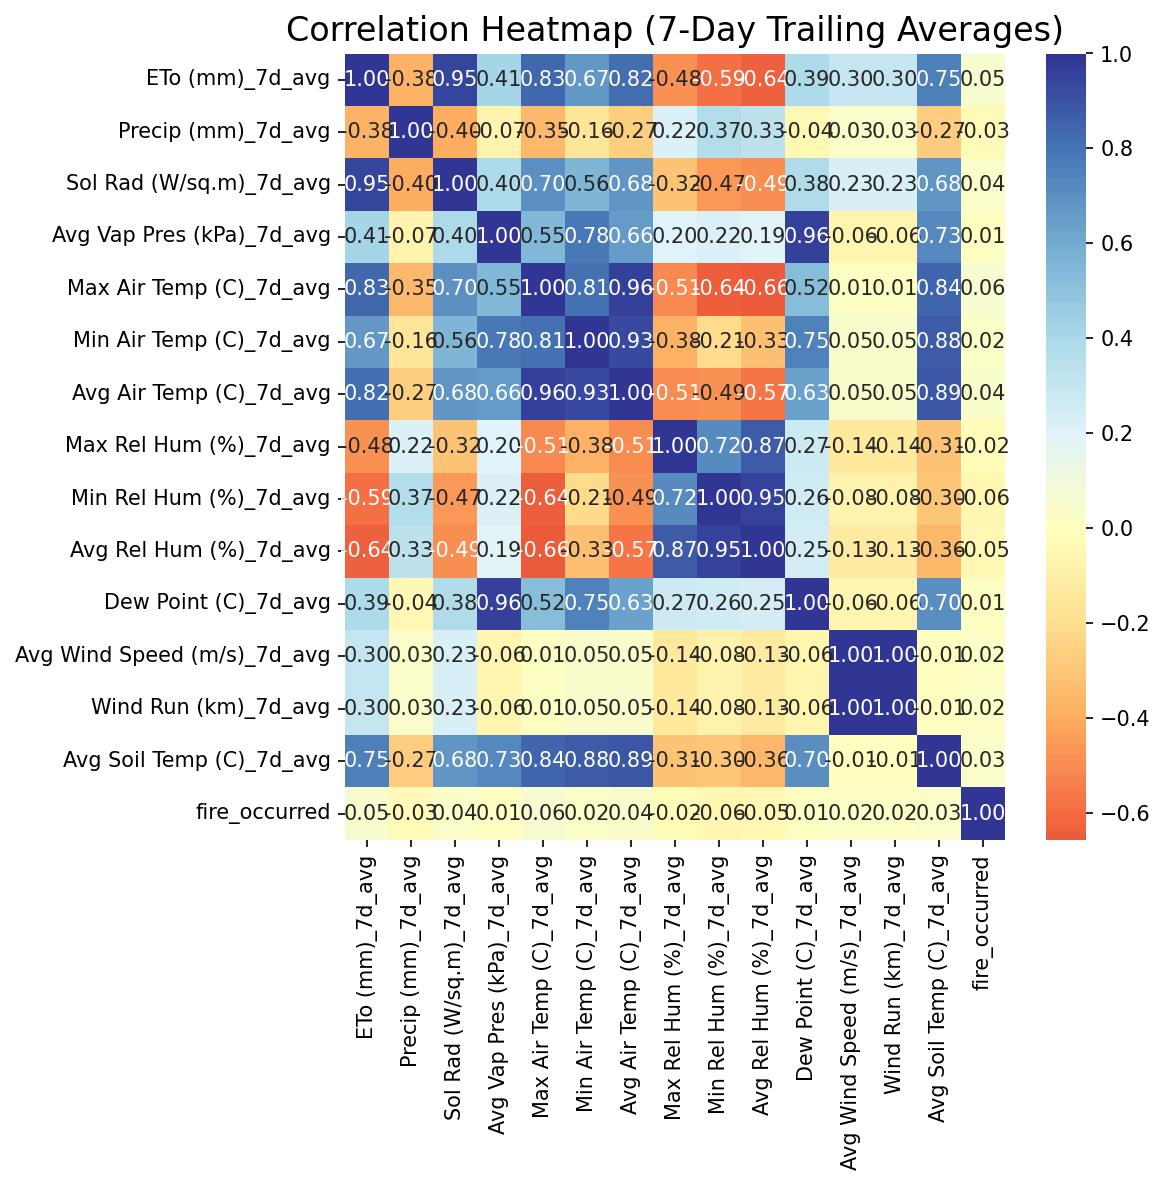

In [238]:
plt.figure(figsize=(8, 8), dpi=150)
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdYlBu',
    center=0
)
plt.title("Correlation Heatmap (7-Day Trailing Averages)", fontsize=16)
plt.tight_layout()
plt.show()

In [240]:
RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42) #fix class imbalanced

RandomForestClassifier(class_weight='balanced', random_state=42)

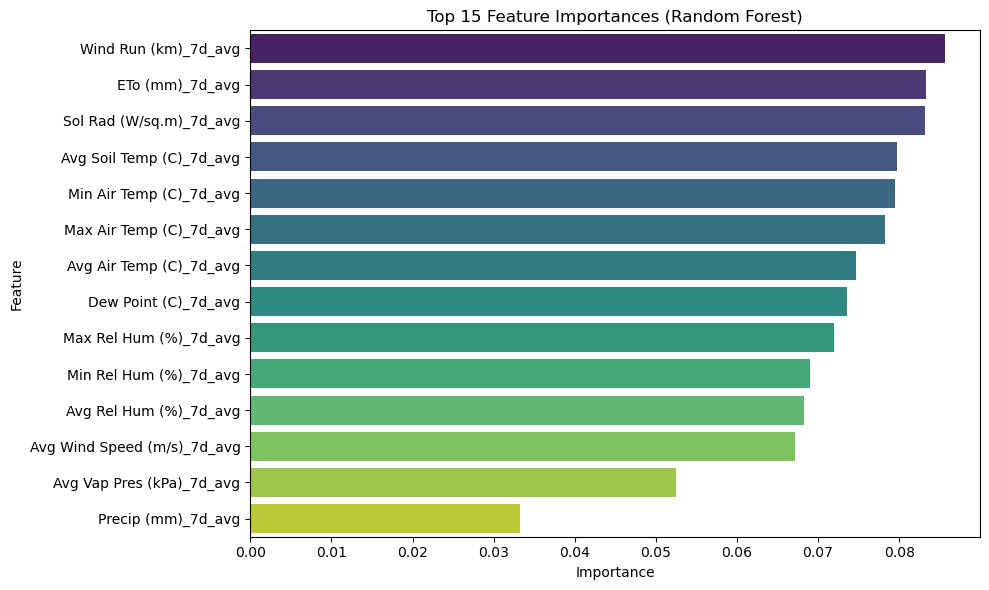

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     36307
           1       1.00      0.05      0.10       427

    accuracy                           0.99     36734
   macro avg       0.99      0.53      0.55     36734
weighted avg       0.99      0.99      0.98     36734



In [242]:
#Select features and target
all_trailing_features = [col for col in cleaned_data.columns if '_7d_avg' in col]
X = cleaned_data[all_trailing_features]
y = cleaned_data['fire_occurred']

#Drop missing values
X = X.dropna()
y = y.loc[X.index]

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#quick standardization (just in case for later)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

#Feature importances
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

#plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df.head(15),
    hue='Feature',
    palette='viridis',
    legend=False
)
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

#classification report
y_pred = rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

In [243]:
# Estimate imbalance ratio
imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

#XGBoost with class weight
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=imbalance_ratio, #handles the imbalanced data
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train_scaled, y_train)

# Predict + evaluate
y_pred = xgb.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.74      0.85     36307
           1       0.03      0.73      0.06       427

    accuracy                           0.74     36734
   macro avg       0.51      0.73      0.45     36734
weighted avg       0.98      0.74      0.84     36734



In [244]:
xgb.fit(X_train_scaled, y_train) #fit the quick model to evaluate
y_pred = xgb.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.74      0.85     36307
           1       0.03      0.73      0.06       427

    accuracy                           0.74     36734
   macro avg       0.51      0.73      0.45     36734
weighted avg       0.98      0.74      0.84     36734

